<a href="https://colab.research.google.com/github/ahmabboud/FellowAI/blob/main/Engagement_Recognition_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engagement Recognition using Densenet161

In [ ]:
#from fastai.utils.show_install import *
#show_install()

#!pip install fastai


In [ ]:
from fastai.vision import *

import pandas as pd
import numpy as np
import os
import shutil
from itertools import chain
import matplotlib.pyplot as plt

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training a model for 4 classes

In [ ]:
path = Path("/content/drive/My Drive/FellowAI")

In [ ]:
path.ls()

[PosixPath('/content/drive/My Drive/FellowAI/emo_data'),
 PosixPath('/content/drive/My Drive/FellowAI/dataset'),
 PosixPath('/content/drive/My Drive/FellowAI/Dataset_Emo'),
 PosixPath('/content/drive/My Drive/FellowAI/10_tutorial.pets.ipynb'),
 PosixPath('/content/drive/My Drive/FellowAI/Models'),
 PosixPath('/content/drive/My Drive/FellowAI/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/FellowAI/Videos'),
 PosixPath('/content/drive/My Drive/FellowAI/temp'),
 PosixPath('/content/drive/My Drive/FellowAI/Engagement_Recognition.ipynb'),
 PosixPath('/content/drive/My Drive/FellowAI/MetaOptNet'),
 PosixPath('/content/drive/My Drive/FellowAI/PT_MAP'),
 PosixPath('/content/drive/My Drive/FellowAI/Scrum.gslides')]

In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
# create dataBunch
#data = ImageDataBunch.from_folder(path/"emo_data", train=".", valid_pct=0.2, size=224, bs=64, num_workers=8).normalize(imagenet_stats)
#data = ImageDataBunch.from_folder(path/"dataset/Merged_All", train=".", valid_pct=0.2,ds_tfms=get_transforms(), size=224, bs=64, num_workers=8).normalize(imagenet_stats)
data = ImageDataBunch.from_folder(path/"Dataset_Emo/DS_V3", train=".", valid_pct=0.2, ds_tfms=get_transforms(),size=224,bs=16, num_workers=4).normalize(imagenet_stats)

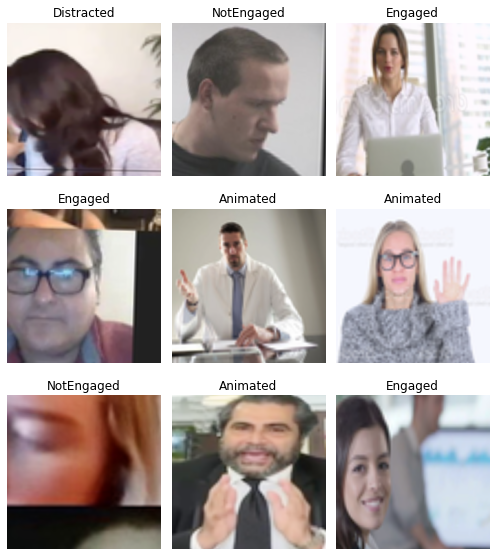

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Animated', 'Distracted', 'Engaged', 'NotEngaged'], 4, 3190, 797)

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
vc

Animated       772
Distracted    1009
Engaged        537
NotEngaged     872
dtype: int64

## Train Model DensNet161

In [ ]:
f1_score = FBeta(average='weighted', beta=1)

In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=[accuracy, f1_score])


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affin

In [ ]:
# Drop out
#children(learn.model)[idx_of_the_layer].p = what_you_want
children(learn.model)[1][7].p = 0.6

In [ ]:
#learn.show_tfms()

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.262632,0.815710,0.749059,0.749704,02:26
1,0.752771,0.576160,0.803011,0.802643,02:26


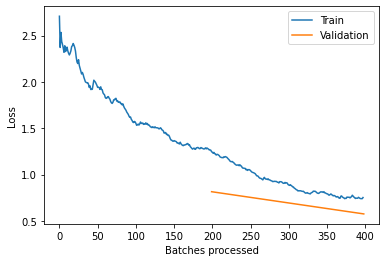

In [ ]:
learn.recorder.plot_losses()

In [ ]:

learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.model_dir

'/content/drive/My Drive/FellowAI/Models'

In [ ]:

learn.save("stage-1_Dens161")

In [ ]:
learn.load('stage-1_Dens161')
print("Success Loaded")

Success Loaded


In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-08


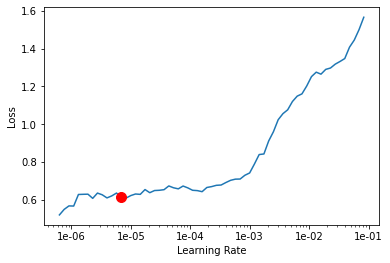

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))
learn.fit_one_cycle(3, max_lr=6.92E-06)


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.621892,0.562775,0.815558,0.814899,03:13
1,0.651852,0.528939,0.820577,0.820831,03:13
2,0.558289,0.527563,0.833124,0.832902,03:14


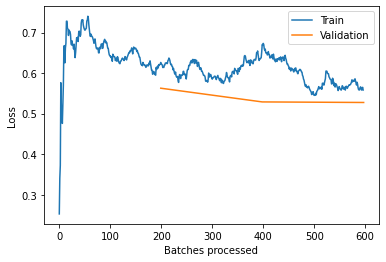

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-2_Dens161")

In [ ]:
learn.load('stage-2_Dens161')
print("Success Loaded")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

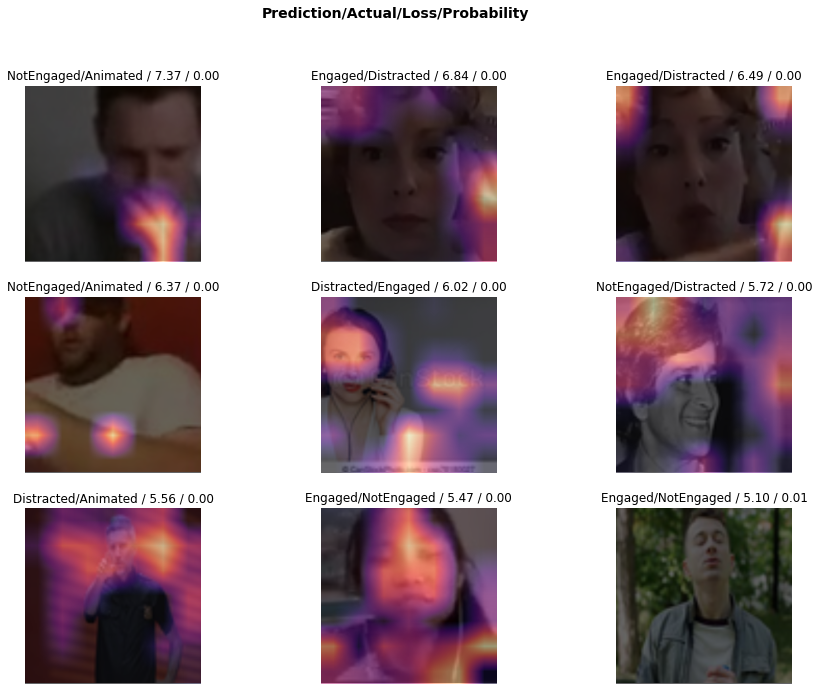

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

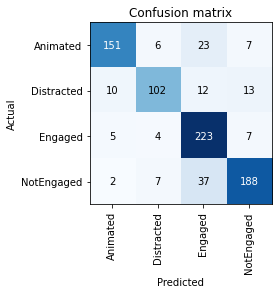

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.model_dir

'/content/drive/My Drive/FellowAI/Models'

In [ ]:
# export the model
learn.export('/content/drive/My Drive/FellowAI/Models/export_Dens161.pkl')

In [ ]:
#defaults.device = torch.device('cpu')

# Testing the Model on a Gallery view image

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,922 kB/s)
debconf: unable to initi

In [ ]:
import cv2
import pytesseract as pt
from PIL import ImageChops 
from difflib import SequenceMatcher
from collections import defaultdict
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import math



In [ ]:
# split screens for gallery view


def read_trim_image(image_path):
    #img = Image.open(image_path)
    img = image_path
    width, height = img.size

    for i in range(width-300, width):
        for j in range(height-50, height):
            img.putpixel((i, j), (0, 0, 0))
    print(f"inside trim_image :{img}")
    
    return trim(img)

def grid_dim(num_participants):
    x = math.sqrt(num_participants)
    if (math.floor(x)*math.ceil(x) >= num_participants):
        rows = int(math.floor(x))
        cols = int(math.ceil(x))
    else:
        rows = int(math.ceil(x))
        cols = int(math.ceil(x))

    return (rows, cols)

def trim(im):
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    
def partitions(grid_dim, img_dim):
    window_width = int(img_dim[0])/int(grid_dim[1])
    window_height = int(img_dim[1])/int(grid_dim[0])
    x_partitons = [ (i*window_width,  i*window_width+window_width) for i in range(grid_dim[1])]
    y_partitons = [ (i*window_height,  i*window_height+window_height) for i in range(grid_dim[0])]

    return x_partitons, y_partitons

def get_participants_screens(img, num_participants):
    dim = grid_dim(num_participants)

    is_margin = False
    if(dim[0]*dim[1] > num_participants):
        is_margin = True

    img_copy = img.copy() 
    processed = 0 
    x_coord, y_coord = partitions(dim, img.size)
    for i, (y1, y2) in enumerate(y_coord):
        if (i >= len(y_coord)-1 and is_margin):
            img_crop = img.crop((0, y1, img.size[0], img.size[1]))
            img_trim = trim(img_crop)
            y1, y2 = 0, img_trim.size[1]
            img_copy = img_trim

        for x1, x2 in x_coord:
            img_crop = img_copy.crop((x1, y1, x2, y2))
            processed+=1

            yield img_crop

            if(processed >= num_participants):
                break

                
def plot_images(images, num_participants):
    dim = grid_dim(num_participants)

    fig, axes = plt.subplots(dim[0], dim[1], figsize=(15,8))
    cnt = 0 
    for i in range(dim[0]):
        for j in range(dim[1]):
            if (dim[0] == 1):
                axes[j].imshow(np.asarray(images[cnt]))
            else:
                axes[i][j].imshow(np.asarray(images[cnt]))
            cnt+=1
            if(cnt >= num_participants):
                break

    plt.show()
    
def extract_users_frames(img_path, num_participants, plot=False):
    image_orig = read_trim_image(img_path)
    print(image_orig)
    num_participants = num_participants
    images = []

    for img in get_participants_screens(image_orig, num_participants):
        images.append(img)

    if plot:
        plot_images(images, num_participants)
    
    return images

In [ ]:
# ocr for speaker ID

def binarization(image):
    '''
    Assigns 255 to light pixels, and 0 to black ones.
    '''
    lower_black = np.array([0,0,0], dtype = "uint16")
    upper_black = np.array([160,160,160], dtype = "uint16")
    return cv2.inRange(image, lower_black, upper_black) 

def crop_img_left_buttom(img, x_percent,y_percent):
    '''
    Crop image forcusing on the left buttom corner.
    
    x_percent - how much to cut from left to right.
    y_percent - how much to cut from top to buttom.
    '''
    h,w = img.shape
    new_h = int(y_percent*h)
    new_w = int(x_percent*w)
    
    return img[new_h:h,:new_w]

def erode(image):
    '''
    Erosion (makes black text thicker).
    '''
    kernel = np.ones((2,2),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

In [ ]:
# get Speaker name from screen

def get_words_similarity(word1,word2):
    return SequenceMatcher(None,word1,word2).ratio()


def process_img(img, img_mean_value_threshold=3.6):
    preprocessed_img = binarization(img)
    # preprocessed_img = erode(preprocessed_img)
    preprocessed_img = crop_img_left_buttom(preprocessed_img,0.21,0.94)
      
    return preprocessed_img  

def get_active_speaker(frame, participants):
  
    frame_processed = process_img(frame)

    if (frame_processed.mean() < 200):
        speaker = '<unknown>'

    text = pt.image_to_string(frame_processed)
    if text in participants:
        speaker = text    
    else:
        speaker = ''
        for attendee in participants:
            # if predicted text is 85% similiar to an attendee name
            if get_words_similarity(attendee,text)>0.85:
                speaker = attendee
                break

    speaker = speaker if speaker else '<unknown>'
    return speaker

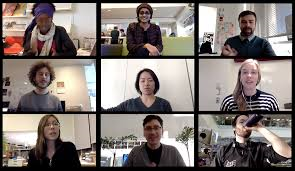

In [ ]:
img = open_image('/content/drive/My Drive/FellowAI/temp/meetingtest.png')
img

In [ ]:
# loads the export.pkl file
learn = load_learner(path/"Models")

inside trim_image :<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=295x171 at 0x7F2B8AC4FF28>
<PIL.Image.Image image mode=RGBA size=290x118 at 0x7F2B8AC4FBA8>


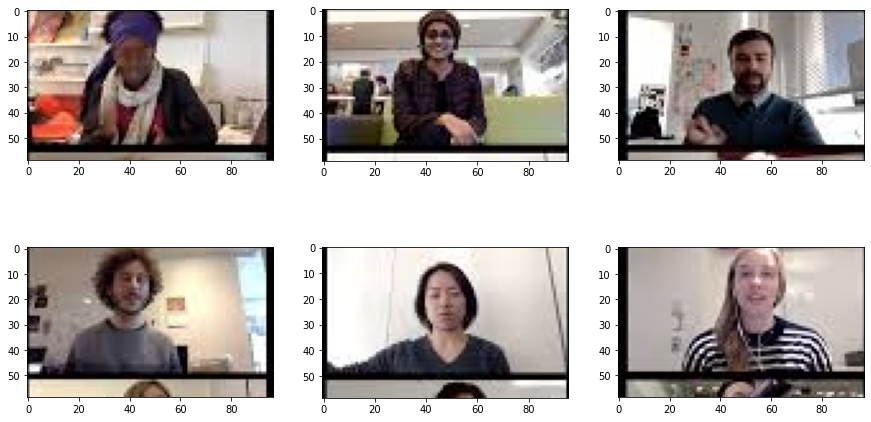

In [ ]:
# Split a Gallery view frame into individual screens
# num_participants defines no. of participants that have their video on

num_participants = 6
frame_pil = PIL.Image.open('/content/drive/My Drive/FellowAI/temp/meetingtest.png')

images = extract_users_frames(frame_pil, num_participants, plot=True)

In [ ]:
# Classify each image for its emotion.
# participants lists is a requirement in getting speaker name and we get it from Zoom API

participants = ['Marko Mandic', 'Venkatesh Narayana','x','y','z','h']
for i in images:
    img = cv2.cvtColor(np.array(i), cv2.COLOR_RGB2BGR)

    # get name of the person from screen
    speaker = get_active_speaker(img, participants)

    # convert image to fastai image
    t = torch.tensor(np.ascontiguousarray(np.flip(img, 2)).transpose(2,0,1)).float()/255
    img = Image(t) 

    # Predict the emotion using the trained model
    pred_class,pred_idx,outputs = learn.predict(img)
    prediction = (pred_class.obj, outputs.data.cpu().numpy().max())
    print(speaker, prediction)
    

<unknown> ('Distracted', 0.9998839)
<unknown> ('Distracted', 0.9996935)
<unknown> ('Distracted', 0.9974311)
<unknown> ('Distracted', 1.0)
<unknown> ('Distracted', 0.9999044)
<unknown> ('Distracted', 0.99997413)


# Generate demo video
The code below draws the predicted emotions over each frame in a video.

In [ ]:
import cv2
# from PIL import Image,ImageChops 

In [ ]:
video_path = "/content/output1.mp4"

In [ ]:
def draw_emotion(frame, prediction):
    """
    """
    color = (0, 0, 255)
    final_emotion = "{}: {}".format(prediction[0], "{:.2f}".format(prediction[1]))
    cv2.putText(
      frame,
      final_emotion,
      (
          35, 50
      ),
      cv2.FONT_HERSHEY_SIMPLEX,
      1,
      color,
      2,
      cv2.LINE_AA,
    )

In [ ]:
vidPath = video_path
outfile = "test_engagement.avi"
index = 1
learn = load_learner(path/"emo_data")
# speaker_emo = defaultdict(list)

cap = cv2.VideoCapture(vidPath)
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = int(cv2.VideoWriter_fourcc('X','V','I','D')) # XVID codecs


writer = cv2.VideoWriter(outfile,fourcc,fps,size)
cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret = True # has frame returned
while(cap.isOpened() and ret and writer.isOpened()):
    ret, frame = cap.read()
    if not ret:
      break
    # Get frame timestamp
    frame_timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
    # fetch frame every sec
    if frame_timestamp >= (index * 1000.0):
        index = index + 1

        t = torch.tensor(np.ascontiguousarray(np.flip(frame, 2)).transpose(2,0,1)).float()/255
        img = Image(t) 
        pred_class,pred_idx,outputs = learn.predict(img)
        prediction = (pred_class.obj, outputs.data.cpu().numpy().max())

    if frame_timestamp >= 1000.0:
        draw_emotion(frame, prediction)
        writer.write(frame)
        
    if index == 50:
          break
        
cap.release    
writer.release()

25
